## Time Series Feature
This was overwhelmingly the dominant function when profiling the original. Futhermore, it uses a two level explicit loop for calculating cross correlations, which should be easy to optimise, so it is an obvious target for refactoring.

### Confirm behaviour of feature_time_series

Note that this uses the random module so we have to be sure a fixed seed is set. There is also an issue between python 2 and python 3 in that the draws provided by ransom.sample() are different between the versions even though
the seeds are the same. This is an issue in testing but doesn't affect us here as we'll use the same version of python for both.

In [1]:
from __future__ import division, print_function
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import random
import os
from tempfile import mkdtemp, mkstemp
from os.path import join
from subprocess import call, check_output, Popen, PIPE

In [2]:
def original_feature_time_series(melmix, mc):
    """ This function extracts the maximum RP correlation feature scores.
    It determines the maximum robust correlation of each component time-series with a model of 72
    realigment parameters.
    Parameters
    ---------------------------------------------------------------------------------
    melmix: Full path of the melodic_mix text file
    mc:     Full path of the text file containing the realignment parameters

    Returns
    ---------------------------------------------------------------------------------
    maxRPcorr: Array of the maximum RP correlation feature scores for the components of the melodic_mix file"""

    # Read melodic mix file (IC time-series), subsequently define a set of squared time-series
    mix = np.loadtxt(melmix)
    mixsq = np.power(mix, 2)

    # Read motion parameter file
    RP6 = np.loadtxt(mc)

    # Determine the derivatives of the RPs (add zeros at time-point zero)
    RP6_der = np.array(RP6[range(1,RP6.shape[0]),:] - RP6[range(0,RP6.shape[0]-1),:])
    RP6_der = np.concatenate((np.zeros((1,6)),RP6_der),axis=0)

    # Create an RP-model including the RPs and its derivatives
    RP12 = np.concatenate((RP6,RP6_der),axis=1)

    # Add the squared RP-terms to the model
    RP24 = np.concatenate((RP12,np.power(RP12,2)),axis=1)

    # Derive shifted versions of the RP_model (1 frame for and backwards)
    RP24_1fw = np.concatenate((np.zeros((1,24)),np.array(RP24[range(0,RP24.shape[0]-1),:])),axis=0)
    RP24_1bw = np.concatenate((np.array(RP24[range(1,RP24.shape[0]),:]),np.zeros((1,24))),axis=0)

    # Combine the original and shifted mot_pars into a single model
    RP_model = np.concatenate((RP24,RP24_1fw,RP24_1bw),axis=1)

    # Define the column indices of respectively the squared or non-squared terms
    idx_nonsq = np.array(np.concatenate((range(0,12), range(24,36), range(48,60)),axis=0))
    idx_sq = np.array(np.concatenate((range(12,24), range(36,48), range(60,72)),axis=0))

    # Determine the maximum correlation between RPs and IC time-series
    nSplits=int(1000)
    maxTC = np.zeros((nSplits,mix.shape[1]))
    for i in range(0,nSplits):
        # Get a random set of 90% of the dataset and get associated RP model and IC time-series matrices
        idx = np.array(random.sample(range(0,mix.shape[0]),int(round(0.9*mix.shape[0]))))
        RP_model_temp = RP_model[idx,:]
        mix_temp = mix[idx,:]
        mixsq_temp = mixsq[idx,:]

        # Calculate correlation between non-squared RP/IC time-series
        RP_model_nonsq = RP_model_temp[:,idx_nonsq]
        cor_nonsq = np.array(np.zeros((mix_temp.shape[1],RP_model_nonsq.shape[1])))
        for j in range(0,mix_temp.shape[1]):
            for k in range(0,RP_model_nonsq.shape[1]):
                cor_temp = np.corrcoef(mix_temp[:,j],RP_model_nonsq[:,k])
                cor_nonsq[j,k] = cor_temp[0,1]

        # Calculate correlation between squared RP/IC time-series
        RP_model_sq = RP_model_temp[:,idx_sq]
        cor_sq = np.array(np.zeros((mix_temp.shape[1],RP_model_sq.shape[1])))
        for j in range(0,mixsq_temp.shape[1]):
            for k in range(0,RP_model_sq.shape[1]):
                cor_temp = np.corrcoef(mixsq_temp[:,j],RP_model_sq[:,k])
                cor_sq[j,k] = cor_temp[0,1]

        # Combine the squared an non-squared correlation matrices
        corMatrix = np.concatenate((cor_sq,cor_nonsq),axis=1)

        # Get maximum absolute temporal correlation for every IC
        corMatrixAbs = np.abs(corMatrix)
        maxTC[i,:] = corMatrixAbs.max(axis=1)

    # Get the mean maximum correlation over all random splits
    maxRPcorr = maxTC.mean(axis=0)

    # Return the feature score
    return maxRPcorr

In [3]:
def cross_correlation(a, b):
    assert a.ndim == b.ndim == 2
    _, ncols_a = a.shape
    return np.corrcoef(a.T, b.T)[:ncols_a, ncols_a:]

def new_feature_time_series(mix, rparams, seed=None):
    assert mix.ndim == rparams.ndim == 2
    _, nparams = rparams.shape

    if seed is not None:
        random.seed(seed)

    # RP model including the RPs, their derivatives, and time shifted versions of each
    rp_derivs = np.vstack((
        np.zeros(nparams),
        np.diff(rparams, axis=0)
    ))
    rp12 = np.hstack((rparams, rp_derivs))
    rp12_1fw = np.vstack((
        np.zeros(2*nparams),
        rp12[:-1]
    ))
    rp12_1bw = np.vstack((
        rp12[1:],
        np.zeros(2*nparams)
    ))
    rp_model = np.hstack((rp12, rp12_1fw, rp12_1bw))

    # Determine the maximum correlation between RPs and IC time-series
    nsplits = 1000
    nmixrows, nmixcols = mix.shape
    nrows_to_choose = int(round(0.9 * nmixrows))

    # Max correlations for multiple splits of the dataset (for a robust estimate)
    max_correls = np.empty((nsplits, nmixcols))
    for i in range(nsplits):
        # Select a random subset of 90% of the dataset rows (*without* replacement)
        chosen_rows = random.sample(population=range(nmixrows), k=nrows_to_choose)

        # Combined correlations between RP and IC time-series, squared and non squared
        correl_nonsquared = cross_correlation(mix[chosen_rows], rp_model[chosen_rows])
        correl_squared = cross_correlation(mix[chosen_rows]**2, rp_model[chosen_rows]**2)
        correl_both = np.hstack((correl_squared, correl_nonsquared))

        # Maximum absolute temporal correlation for every IC
        max_correls[i] = np.abs(correl_both).max(axis=1)

    # Feature score is the mean of the maximum correlation over all the random splits
    return max_correls.mean(axis=0)


In [4]:
SEED = 31415926
MELMIX = '../test/refout/melodic.ica/melodic_mix'
MC = '../test/refin/mc/prefiltered_func_data_mcf.par'

random.seed(SEED)
original_max_rp_correl = original_feature_time_series(
    MELMIX,
    MC
)

new_max_rp_correl = new_feature_time_series(
    np.loadtxt(MELMIX),
    np.loadtxt(MC),
    seed=SEED
)

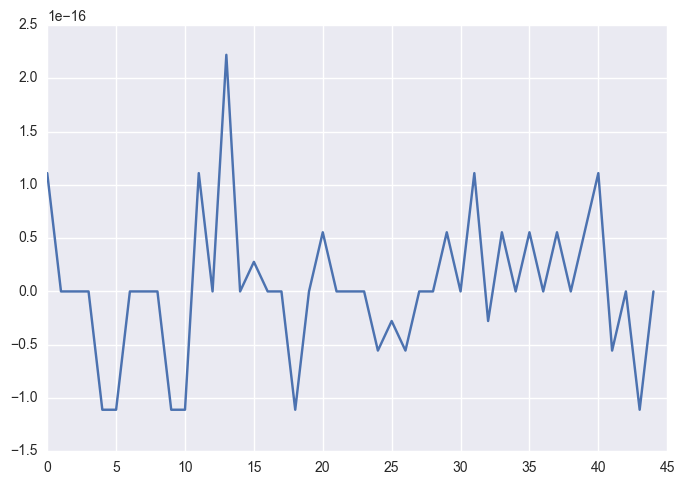

In [5]:
plt.plot(new_max_rp_correl - original_max_rp_correl);

OK, these seem pretty much identical now. We'll just use an item in the test suite for this.

In [6]:
random.seed(SEED)
%timeit original_feature_time_series(MELMIX, MC)

%timeit new_feature_time_series(np.loadtxt(MELMIX), np.loadtxt(MC), seed=SEED)

1 loop, best of 3: 4min 24s per loop
1 loop, best of 3: 963 ms per loop


Really large speed up here (about 250x). No suprise really considering the original used explicit looping. As this was the slowest step in the profiling this should have a big impact on the speed overall. 